In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\HP\AppData\Local\Temp/ipykernel_17804/950759743.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df=pd.read_csv('gold_price_data.csv') #reading the data 
df.head()

,Date,Value
0,01/01/1970,35.2
1,01/04/1970,35.1
2,01/07/1970,35.4
3,01/10/1970,36.2
4,01/01/1971,37.4


In [3]:
df.columns

Index(['Date', 'Value'], dtype='object')

In [4]:
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True,format='%d/%m/%Y') #change the date type to date format

In [5]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [6]:
df.set_index('Date',inplace=True) #coverting Date cloum into index

In [7]:
df.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


<AxesSubplot:xlabel='Date'>

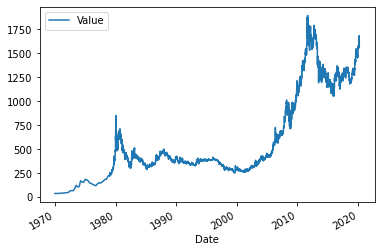

In [8]:
df.plot()

In [9]:
df.isna().sum()  #checking for null values

Value    0
dtype: int64

In [10]:
timeSeries = df.copy()

In [11]:
timeSeries.index = pd.DatetimeIndex(timeSeries.index).to_period('D')

Checking the Data is stationary or not

array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

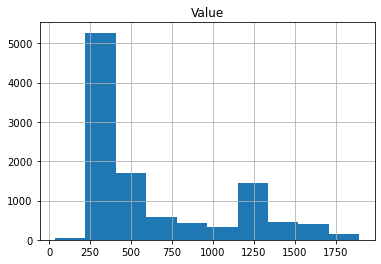

In [12]:
timeSeries.hist()

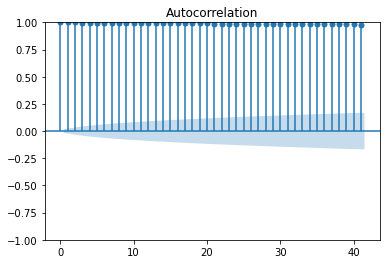

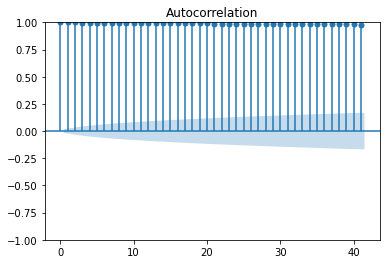

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(timeSeries)

In [14]:
timeSeries.shape

(10787, 1)

In [15]:
data1 = timeSeries[0:5394]
data2 = timeSeries[5394:]

In [16]:
data1.size

5394

In [17]:
data2.size

5393

In [18]:
data1.mean()

Value    381.351481
dtype: float64

In [19]:
data2.mean()

Value    925.892268
dtype: float64

In [20]:
data1.var()

Value    6167.576533
dtype: float64

In [21]:
data2.var()

Value    222363.129839
dtype: float64

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
test_result=adfuller(timeSeries['Value'])

In [24]:
def adfuller_test(Value):
    result=adfuller(Value)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

adfuller_test(timeSeries['Value'])

ADF Test Statistic : -0.07112124453813365
p-value : 0.9522400769147396
#Lags Used : 39
Number of Observations : 10747
Data is non-stationary 


Change the data to stationary

In [25]:
timeSeries['First Difference'] = timeSeries.diff().dropna()

In [26]:
timeSeries['Seasonal First Difference']=timeSeries['Value']-timeSeries['Value'].shift(12)

In [27]:
timeSeries.head(20)

,Value,First Difference,Seasonal First Difference
Date,,,
1970-01-01,35.2,NaN,NaN
1970-04-01,35.1,-0.1,NaN
1970-07-01,35.4,0.3,NaN
1970-10-01,36.2,0.8,NaN
1971-01-01,37.4,1.2,NaN
1971-04-01,38.9,1.5,NaN
1971-07-01,40.1,1.2,NaN
1971-10-01,42.0,1.9,NaN
1972-01-03,43.5,1.5,NaN


In [28]:
adfuller_test(timeSeries['Seasonal First Difference'].dropna())

ADF Test Statistic : -14.980483866744715
p-value : 1.1640981457203492e-27
#Lags Used : 39
Number of Observations : 10735
Data is stationary


In [29]:
adfuller_test(timeSeries['First Difference'].dropna())

ADF Test Statistic : -17.568807521617266
p-value : 4.061374360447349e-30
#Lags Used : 38
Number of Observations : 10747
Data is stationary


<AxesSubplot:xlabel='Date'>

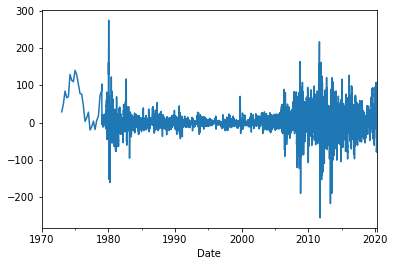

In [30]:
timeSeries['Seasonal First Difference'].plot()

<AxesSubplot:xlabel='Date'>

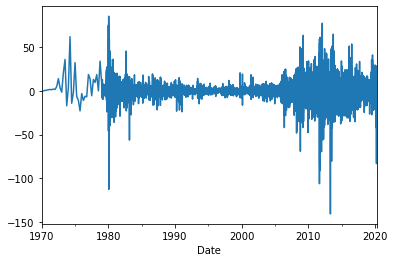

In [31]:
timeSeries['First Difference'].plot()

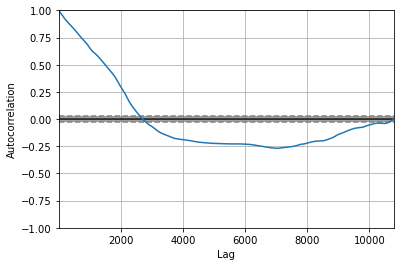

In [32]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(timeSeries['Value'])
plt.show()

Identify the parameters(p,d,q)

In [33]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

E:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


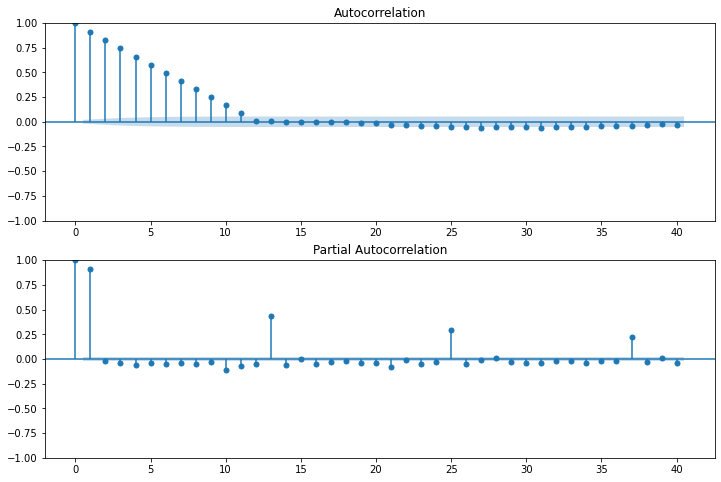

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeSeries['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeSeries['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [35]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(timeSeries['Value'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78048.396, Time=35.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78090.196, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78090.620, Time=1.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78090.554, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78090.847, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=78081.191, Time=16.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=78081.126, Time=15.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=78049.953, Time=35.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=78084.745, Time=22.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78088.281, Time=13.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=78082.704, Time=13.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=78082.775, Time=17.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=78086.029, Time=51.99 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=78049.141, Time=11.06 sec

Best mod

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
model = ARIMA(timeSeries['Value'], order=(2,1,2))
model_fit_arima=model.fit()

In [38]:
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                10787
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -39019.571
Date:                Sat, 28 May 2022   AIC                          78049.141
Time:                        21:22:46   BIC                          78085.571
Sample:                    01-01-1970   HQIC                         78061.426
                         - 03-13-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7038      0.011    -65.257      0.000      -0.725      -0.683
ar.L2         -0.9375      0.010    -93.265      0.000      -0.957      -0.918
ma.L1          0.6847      0.012     55.853      0.000       0.661       0.709
ma.L2          0.9174      0.012     79.171      0.000       0.895       0.940
sigma2        81.2352      0.325    249.806      0.000      80.598      81.873
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):            210438.72
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

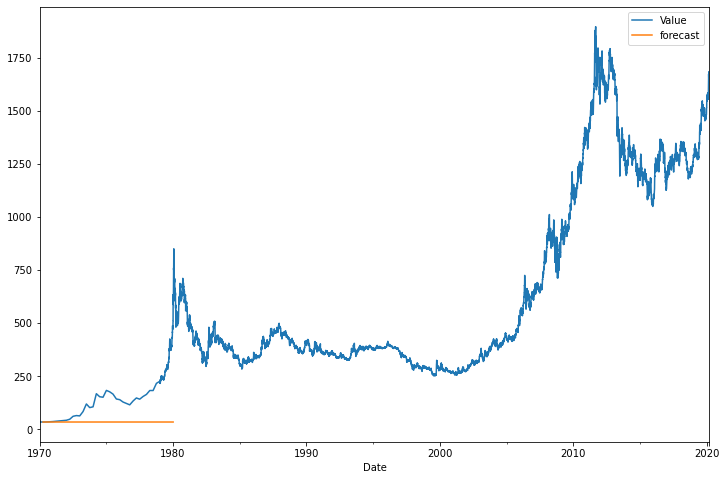

In [40]:
timeSeries['forecast']=model_fit_arima.predict(start= 1,end=300,dynamic=True)
timeSeries[['Value','forecast']].plot(figsize=(12,8))

In [41]:
model=sm.tsa.statespace.SARIMAX(timeSeries['Value'],order=(2, 1, 2),seasonal_order=(2,1,2,12))
results=model.fit()

E:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                10787
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood              -39013.836
Date:                            Sat, 28 May 2022   AIC                          78045.672
Time:                                    21:29:56   BIC                          78111.236
Sample:                                01-01-1970   HQIC                         78067.783
                                     - 03-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5967      0.009    -68.081      0.000      -0.614      -0.580
ar.L2         -0.9490      0.008   -112.903      0.000      -0.965      -0.933
ma.L1          0.5756      0.009     63.676      0.000       0.558       0.593
ma.L2          0.9452      0.009    107.600      0.000       0.928       0.962
ar.S.L12      -0.9497      0.074    -12.789      0.000      -1.095      -0.804
ar.S.L24       0.0194      0.005      3.589      0.000       0.009       0.030
ma.S.L12      -0.0316      0.075     -0.423      0.672      -0.178       0.115
ma.S.L24      -0.9680      0.074    -13.036      0.000      -1.114      -0.822
sigma2        81.0881      0.742    109.321      0.000      79.634      82.542
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):            200811.10
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

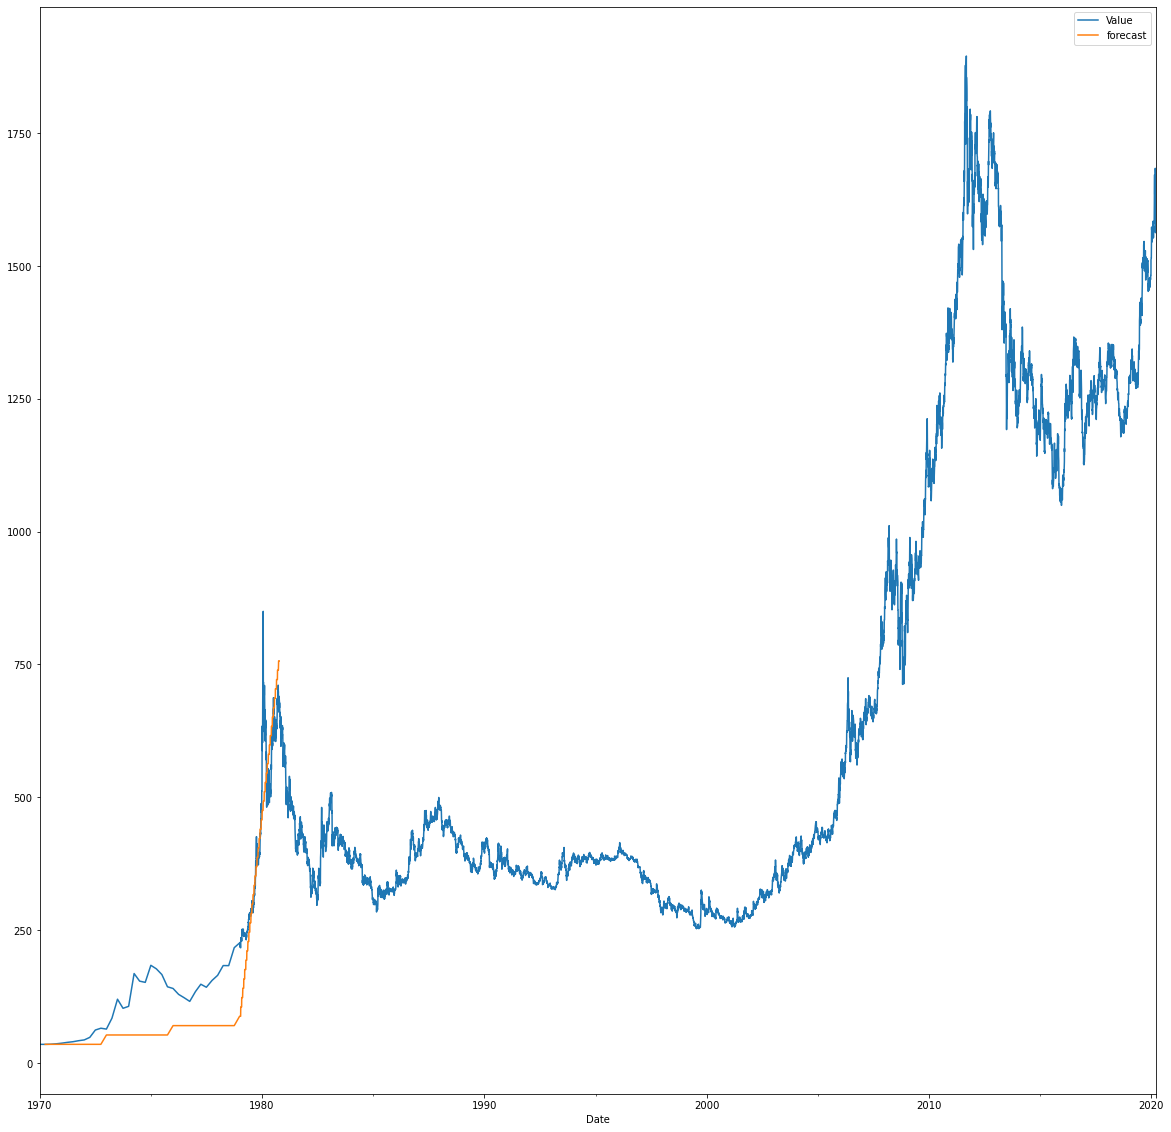

In [44]:
timeSeries['forecast']=results.predict(start= 1,end=500,dynamic=True)
timeSeries[['Value','forecast']].plot(figsize=(20,20))

In [45]:
timeSeries['forecast'].head(300)

Date
1970-01-01           NaN
1970-04-01     35.199941
1970-07-01     35.199963
1970-10-01     35.200004
1971-01-01     35.199960
                 ...    
1979-12-27    457.600001
1979-12-28    457.600000
1979-12-31    457.599994
1980-01-01    457.599997
1980-01-02    457.600004
Freq: D, Name: forecast, Length: 300, dtype: float64

In [46]:
from pandas.tseries.offsets import DateOffset
dates = [(pd.Timestamp('2020-03-13') + DateOffset(days=x)).to_period(freq='D') for x in range(0,2400)]

In [47]:
dates = pd.DataFrame(dates)

In [48]:
dates.columns = ['Date']

In [49]:
dates.set_index('Date',inplace=True)

In [50]:
future_dataset_df = timeSeries.append(dates)

In [51]:
future_dataset_df.tail()

,Value,First Difference,Seasonal First Difference,forecast
Date,,,,
2026-10-03,NaN,NaN,NaN,NaN
2026-10-04,NaN,NaN,NaN,NaN
2026-10-05,NaN,NaN,NaN,NaN
2026-10-06,NaN,NaN,NaN,NaN
2026-10-07,NaN,NaN,NaN,NaN


E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='Date'>

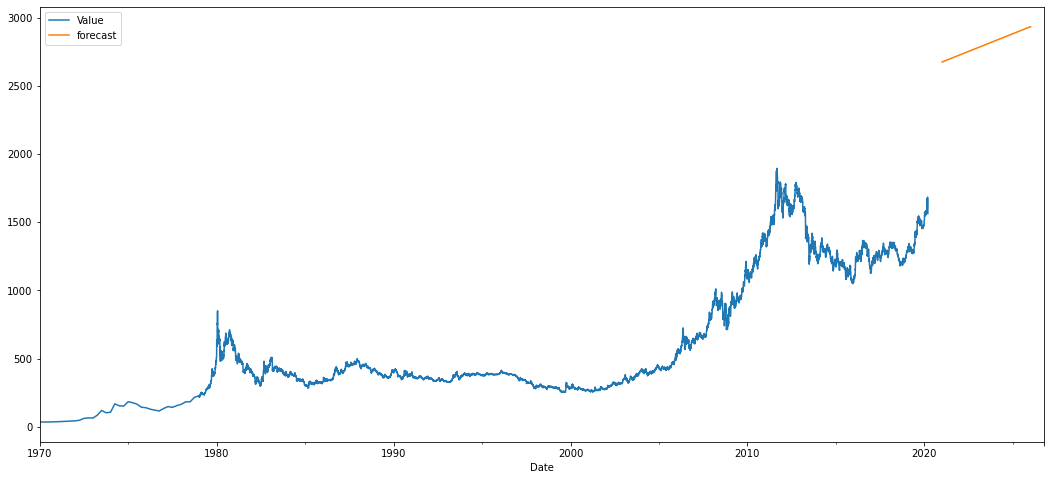

In [52]:
future_dataset_df['forecast'] = results.predict(start = '2021', end = '2026', dynamic= True)  
future_dataset_df[['Value', 'forecast']].plot(figsize=(18, 8)) 